# Common artifacts quantification
In this notebook, we quantify how common some imaging artifacts are across multiple datasets.

## Settings

Load packages

In [1]:
using StatsBase, Statistics, DataFrames, RCall, Random 
using CategoricalArrays
using Dates: now
using DataStructures: DefaultDict

┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1278
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c]
│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.
└ @ Base loading.jl:1042


In [2]:
@rlibrary ggplot2
@rlibrary extrafont

In [3]:
R"""

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
# ttf_import(paths = "/tmp/.fonts/")
# loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2),
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          axis.text = element_text(size=12, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Registering fonts with R
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Loading data

In [4]:
# The following is copied directly from the Excel files in which artifacts were counted
rawCounts = Dict{String, String}()
rawCounts["Rohban et al"] = """-	-	C	S3,C	C	-	-	-	C
S3	C	S3	C,D	-	S3,C	C	S3	S3
-	S3,C	C	C	P	C,D	P	S3,C	-
S3,S4	-	-	S4,C	C	P	S3,C	-	-
C	S3	C	C	C	C,D	C	S3	C
C	S3,C	-	S3,C	C	C	P	C	S3,C"""
rawCounts["Breinig et al"] = """D,P	D	P	P
C	C	C,D	-
D	C,D	C	C
P	-	D	D
C	-	C	-
C,D	S1	C	D,P
D	D	D,P	D,P
S1,D	C	D	C
-	C	C	C
D	S2,C	D	C
C	S1	C	C
D,P	S1,D,P	D	D,P"""
rawCounts["Caldera et al"] = """-	-	-	D
-	C	-	-
C	C,D	-	-
C	-	-	-
-	-	C	D
B	-	-	-
-	-	-	D
-	C	C	-
D	-	C	-
B	C	B,C	C
C	C	-	-
-	-	-	-"""
rawCounts["Gustafsdottir,\nLjosa et al"] = """C	C	-	C	-	B,C	C	-	-
-	C	-	D	-	-	C	-	-
C	-	-	C	C	C	-	-	-
-	-	-	C	-	-	-	-	-
-	-	C	-	-	-	-	-	-
-	-	-	-	C	C	-	-	-"""

"C\tC\t-\tC\t-\tB,C\tC\t-\t-\n-\tC\t-\tD\t-\t-\tC\t-\t-\nC\t-\t-\tC\tC\tC\t-\t-\t-\n-\t-\t-\tC\t-\t-\t-\t-\t-\n-\t-\tC\t-\t-\t-\t-\t-\t-\n-\t-\t-\t-\tC\tC\t-\t-\t-"

In [5]:
# We observe the frequence of each artifact type in the dataset
countEachArtifact(x) = countmap(split(replace(x, '\n' => '\t'), '\t'))
artifactCounts = Dict((k,countEachArtifact(v)) for (k,v) in rawCounts)

Dict{String,Dict{SubString{String},Int64}} with 4 entries:
  "Rohban et al"                => Dict{SubString{String},Int64}("S3,S4"=>1,"S3…
  "Caldera et al"               => Dict{SubString{String},Int64}("B"=>2,"C,D"=>…
  "Breinig et al"               => Dict{SubString{String},Int64}("C,D"=>3,"S1"=…
  "Gustafsdottir,\nLjosa et al" => Dict{SubString{String},Int64}("B,C"=>1,"-"=>…

In [6]:
# We transform these counts to a long DataFrame
artifactTypes = [union([keys(v) for v in values(artifactCounts)]...)...]
datasetNames = keys(artifactCounts)
artifactDF = DataFrame(Artifact = repeat(artifactTypes, length(datasetNames)),
                       Dataset = vcat([[d for _ in 1:length(artifactTypes)] for d in datasetNames]...),
                       Count = 0);

In [7]:
for (dataset, typeCounts) in artifactCounts
    for (artifact, count) in typeCounts
        artifactDF.Count[(artifactDF.Artifact .== artifact).&
                         (artifactDF.Dataset .== dataset)] .= count
    end
end

## Plot proportions

In [8]:
artifactDF

,Artifact,Dataset,Count
,SubStri…,String,Int64
1,"S3,C",Rohban et al,8
2,"B,C",Rohban et al,0
3,C,Rohban et al,18
4,P,Rohban et al,4
5,"S1,D,P",Rohban et al,0
6,"S2,C",Rohban et al,0
7,"S3,S4",Rohban et al,1
8,B,Rohban et al,0
9,S1,Rohban et al,0


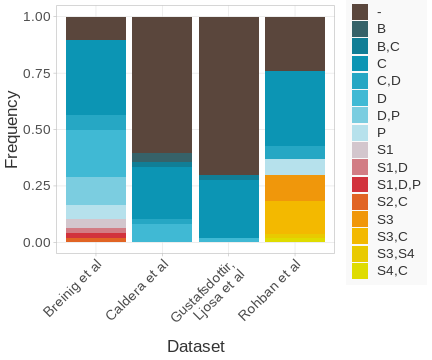

RObject{VecSxp}


In [9]:
ggplot(artifactDF, aes(fill=:Artifact, y=:Count, x=:Dataset)) + 
    geom_bar(position="fill", stat="identity") + ylab("Frequency") +
    #coord_flip() + 
    theme(var"axis.text.x" = element_text(angle = 45, hjust = 1))

## Simplify

In [10]:
newGroups = ["-" => s"No artifact",
             r"S." => s"Other artifact",
             r"B" => s"Other artifact",
             r"P" => s"Precipitation",
             r"C" => s"Precipitation",
             r"D" => s"Detached cell"];

In [11]:
simplifiedArtifactCounts = Dict(k => DefaultDict{SubString{String}, Int64}(0) for k in keys(artifactCounts))
for (dataset, typeCounts) in artifactCounts
    for (artifact, count) in typeCounts
        simplifiedArtifact = reduce(replace, newGroups, init = artifact)
        simplifiedArtifact = join(sort(unique(split(simplifiedArtifact, ','))), ", ")
        simplifiedArtifactCounts[dataset][simplifiedArtifact] += count
    end
end

In [12]:
# We transform these counts to a long DataFrame
artifactTypes = [union([keys(v) for v in values(simplifiedArtifactCounts)]...)...]
datasetNames = keys(simplifiedArtifactCounts)
artifactDF = DataFrame(Artifact = repeat(artifactTypes, length(datasetNames)),
                       Dataset = vcat([[d for _ in 1:length(artifactTypes)] for d in datasetNames]...),
                       Count = 0);

In [13]:
for (dataset, typeCounts) in simplifiedArtifactCounts
    for (artifact, count) in typeCounts
        artifactDF.Count[(artifactDF.Artifact .== artifact).&
                         (artifactDF.Dataset .== dataset)] .= count
    end
end

In [14]:
# Reorder levels
artifactDF.Artifact = CategoricalVector(artifactDF.Artifact)
orderedLevels = ["No artifact",
                 "Precipitation",
                 "Detached cell",
                 "Detached cell, Other artifact",
                 "Detached cell, Other artifact, Precipitation",
                 "Detached cell, Precipitation",
                 "Other artifact",
                 "Other artifact, Precipitation"                 
]
levels!(artifactDF.Artifact, orderedLevels)

32-element CategoricalArray{String,1,UInt32}:
 "Detached cell, Other artifact"
 "Precipitation"
 "Detached cell, Other artifact, Precipitation"
 "Other artifact, Precipitation"
 "No artifact"
 "Detached cell, Precipitation"
 "Detached cell"
 "Other artifact"
 "Detached cell, Other artifact"
 "Precipitation"
 "Detached cell, Other artifact, Precipitation"
 "Other artifact, Precipitation"
 "No artifact"
 ⋮
 "No artifact"
 "Detached cell, Precipitation"
 "Detached cell"
 "Other artifact"
 "Detached cell, Other artifact"
 "Precipitation"
 "Detached cell, Other artifact, Precipitation"
 "Other artifact, Precipitation"
 "No artifact"
 "Detached cell, Precipitation"
 "Detached cell"
 "Other artifact"

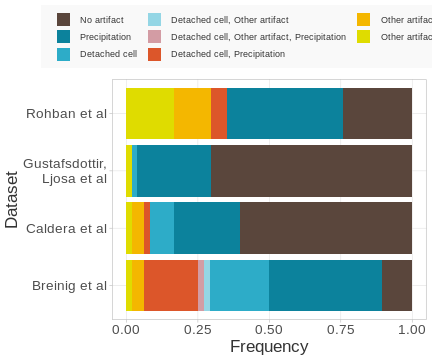

RObject{VecSxp}


In [15]:
gp = ggplot(artifactDF, aes(fill=:Artifact, y=:Count, x=:Dataset))  + 
      geom_bar(position="fill", stat="identity", size = 3) + ylab("Frequency") +  
      guides(fill = guide_legend(nrow=3, title="")) + coord_flip() +
      theme(var"legend.position" = "top",
            var"legend.text" = element_text(size=9), var"legend.box"="vertical")

In [16]:
ggsave("fig/ArtifactsQuant_simple.pdf", gp, width = 8, height = 7)

LoadError: REvalError: Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Error in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  : 
  invalid font type
Calls: <Anonymous> ... drawDetails -> drawDetails.text -> grid.Call.graphics

In [17]:
for ds in unique(artifactDF.Dataset)
    p = artifactDF.Count[(artifactDF.Dataset .== ds).&(artifactDF.Artifact .== "-")]/
        sum(artifactDF.Count[artifactDF.Dataset .== ds])
    println(ds, " ", p)
end

Rohban et al Float64[]
Caldera et al Float64[]
Breinig et al Float64[]
Gustafsdottir,
Ljosa et al Float64[]
